# Bayesian Neural Network - NARX

In [1]:
import torch
device = 'cuda'
if device == 'cuda':
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

In [2]:
import os
import csv
import time
from tqdm.notebook import tqdm, trange
from functools import partial
import numpy as np
import numpy.random as rnd
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [3]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [4]:
from pyro.nn import module
from pyro.nn import PyroSample
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.contrib.bnn import HiddenLayer

In [5]:
from util import summary

## System: Silverbox

In [6]:
# Read data from CSV file
dataset = pd.read_csv('../data/silverbox/SNLS80mV.csv')

# Select input and output signals
input_signal = dataset["V1"].values
output_signal = dataset["V2"].values

# Time horizon
T = np.shape(input_signal)[0]

In [7]:
# NARX orders
order_u = 2
order_y = 2
order = 1 + order_u + order_y

# Initialize feature array
signal_lag = np.zeros((T,order))

# Lagged signals as features
for k in range(max(order_u,order_y),T):
    signal_lag[k,:] = np.hstack(([input_signal[range(k,k-order_u-1,-1)], output_signal[range(k-1,k-order_u-1,-1)]]))

In [8]:
# Split training set
t_trn = range(40101,131072)
u_trn = input_signal[t_trn]
x_trn = signal_lag[t_trn,:]
y_trn = output_signal[t_trn]
T_trn = len(t_trn);

# Split validation set
t_val = range(101,40100)
u_val = input_signal[t_val]
x_val = signal_lag[t_val,:]
y_val = output_signal[t_val]
T_val = len(t_val);

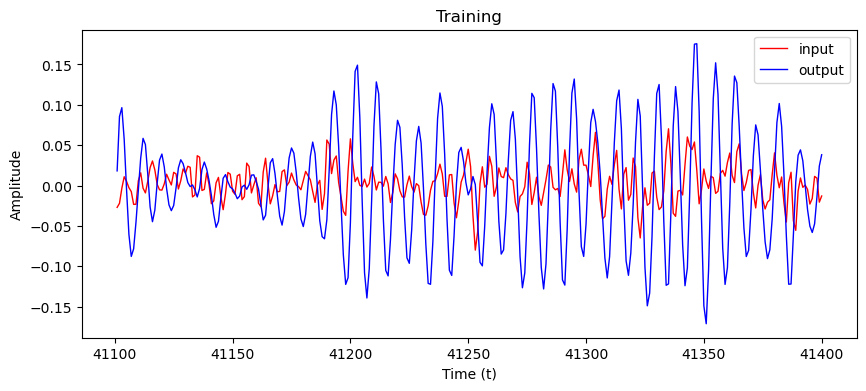

In [9]:
# Plot training signal
zoom = slice(1000,1300)
fig = plt.figure(figsize=(10,4))
ax = fig.subplots(1)
ax.plot(t_trn[zoom], u_trn[zoom], c="red", lw=1, label="input");
ax.plot(t_trn[zoom], y_trn[zoom], c="blue", lw=1, label="output"); 
ax.set_title("Training");
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

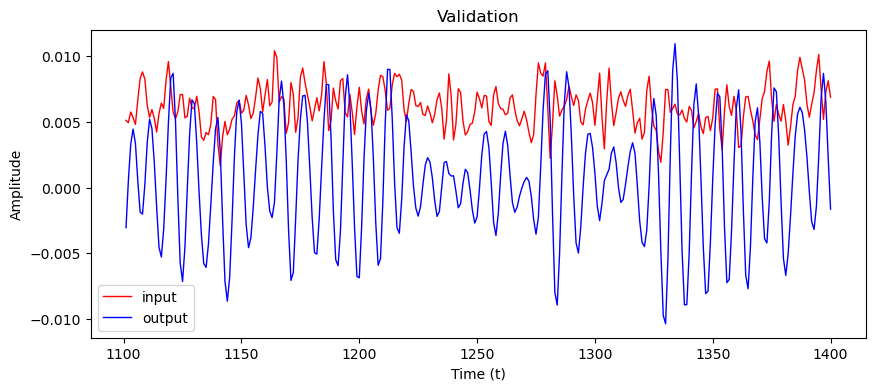

In [10]:
# Plot validation signal
zoom = slice(1000,1300)
fig = plt.figure(figsize=(10,4))
ax = fig.subplots(1)
ax.plot(t_val[zoom], u_val[zoom], c="red", lw=1, label="input");
ax.plot(t_val[zoom], y_val[zoom], c="blue", lw=1, label="output"); 
ax.set_title("Validation");
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [11]:
# Cast to tensors
trn_u = torch.tensor(u_trn, dtype=torch.float).to(device)
trn_x = torch.tensor(x_trn, dtype=torch.float).to(device)
trn_y = torch.tensor(y_trn, dtype=torch.float).to(device)

val_u = torch.tensor(u_val, dtype=torch.float).to('cpu')
val_x = torch.tensor(x_val, dtype=torch.float).to(device)
val_y = torch.tensor(y_val, dtype=torch.float).to('cpu')

## Model 0: Bayesian linear regression

In [12]:
class BayesianLinearRegression(PyroModule):
    def __init__(self, in_features, out_features, device='cpu'):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))
        self.device = device

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 1))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [13]:
# Define model and inference procedure
model = BayesianLinearRegression(order, 1, device=device).to(device)
guide = AutoDiagonalNormal(model)
adam = Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [14]:
pyro.clear_param_store()

# Train model
num_iterations = 5000
for j in trange(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(trn_x, trn_y)
    if j % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / T_trn))

  0%|          | 0/5000 [00:00<?, ?it/s]

[iteration 0001] loss: 0.3816
[iteration 1001] loss: -5.1822
[iteration 2001] loss: -5.5446
[iteration 3001] loss: -5.8296
[iteration 4001] loss: -5.8976


### Model evaluation: 1-step ahead prediction error

In [15]:
# Define prediction model
predictor = Predictive(model, guide=guide, num_samples=1000, return_sites=("obs", "_RETURN"))

# 1-step ahead prediction
samples_prd_BLR = predictor(val_x)
postpred_prd_BLR = summary(samples_prd_BLR)["_RETURN"]
m0_prd_MAP = postpred_prd_BLR["mean"].to('cpu')
m0_prd_σ05 = postpred_prd_BLR["5%"].to('cpu')
m0_prd_σ95 = postpred_prd_BLR["95%"].to('cpu')

# Compute RMS
RMS_prd_BLR = np.array(np.sqrt(torch.mean((val_y - m0_prd_MAP)**2)))

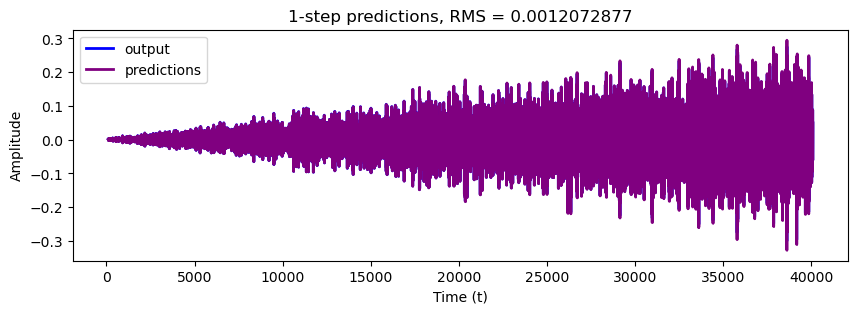

In [16]:
# 1-step ahead predictions
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
# ax.plot(t_val, val_u, c="red", lw=2, label="input")
ax.plot(t_val, val_y, c="blue", lw=2, label="output"); 
ax.plot(t_val, m0_prd_MAP, c="purple", lw=2, label="predictions")
ax.fill_between(t_val, m0_prd_σ05, m0_prd_σ95, color="purple", alpha=0.5)
ax.set_title("1-step predictions, RMS = " + str(RMS_prd_BLR));
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [17]:
fig.savefig("figures/Silverbox-NARX-BLR_1prd-predictions.png");

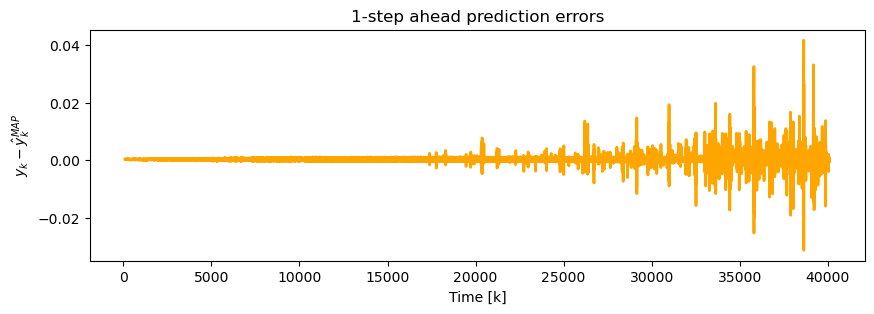

In [18]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.plot(t_val, val_y - m0_prd_MAP, c="orange", lw=2);
ax.set_title("1-step ahead prediction errors");
ax.set_xlabel("Time [k]");
ax.set_ylabel(r"$y_k - \hat{y}_k^{MAP}$");

In [19]:
fig.savefig("figures/Silverbox-NARX-BLR_1prd-errors.png")

### Model evaluation: simulation errors

In [20]:
# Support structures
S = torch.zeros((order_y,order_y)); S[1:,:-1] = torch.eye(order_y-1)
s = torch.zeros((order_y)); s[0] = 1.0

In [21]:
# Define prediction model
predictor = Predictive(model, guide=guide, num_samples=20, return_sites=("obs", "_RETURN"))

# Initial output predictions
# preds_k = torch.zeros((1,order_y),dtype=torch.float)
preds_k = val_y[:order_y].to(device)

# Preallocate for simulation
m0_sim_MAP = np.zeros((T_val,))
m0_sim_σ05 = np.zeros((T_val,))
m0_sim_σ95 = np.zeros((T_val,))

for k in trange(T_val):
    
    # Simulation 
    sim_x = torch.hstack((val_x[k,:order_u+1], preds_k))
    samples_sim_BLR = predictor(sim_x)
    postpred_sim_BLR = summary(samples_sim_BLR)["_RETURN"]
    
    # Keep MAP and interval of posterior predictive
    m0_sim_MAP[k] = postpred_sim_BLR["mean"].to('cpu')
    m0_sim_σ05[k] = postpred_sim_BLR["5%"].to('cpu')
    m0_sim_σ95[k] = postpred_sim_BLR["95%"].to('cpu')
    
    # Update prediction container
    preds_k = S@preds_k + s*postpred_sim_BLR["mean"]

  0%|          | 0/39999 [00:00<?, ?it/s]

In [22]:
# Compute RMS
RMS_sim_BLR = np.array(np.sqrt(torch.mean((val_y - m0_sim_MAP)**2)))    

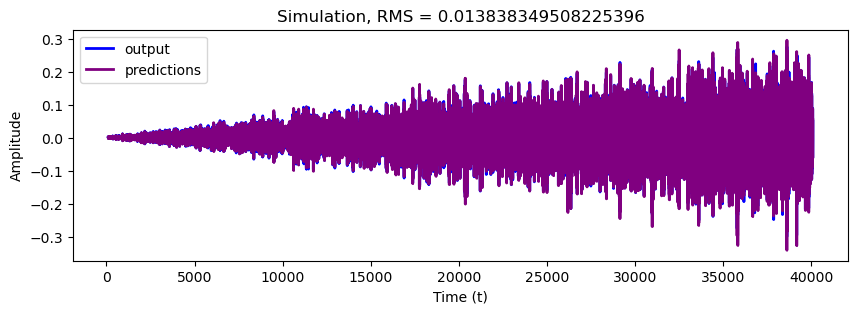

In [23]:
# 1-step ahead predictions
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
# ax.plot(t_val, val_u, c="red", lw=2, label="input")
ax.plot(t_val, val_y, c="blue", lw=2, label="output")
ax.plot(t_val, m0_sim_MAP, c="purple", lw=2, label="predictions")
ax.fill_between(t_val, m0_sim_σ05, m0_sim_σ95, color="purple", alpha=0.5)
ax.set_title("Simulation, RMS = " + str(RMS_sim_BLR));
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [24]:
fig.savefig("figures/Silverbox-NARX-BLR_sim-predictions.png");

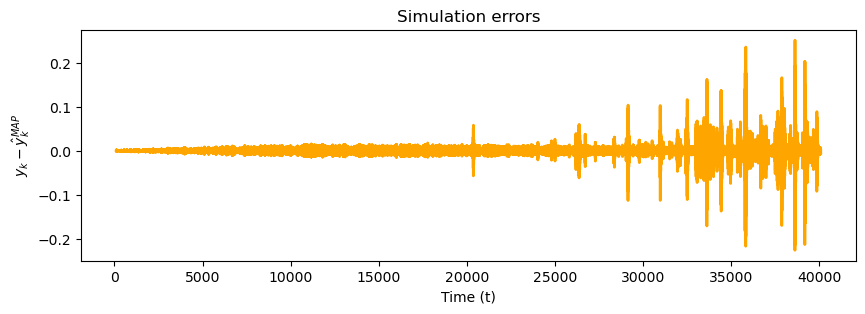

In [25]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.plot(t_val, val_y - m0_sim_MAP, c="orange", lw=2);
ax.set_title("Simulation errors")
ax.set_xlabel("Time (t)");
ax.set_ylabel(r"$y_k - \hat{y}_k^{MAP}$");

In [26]:
fig.savefig("figures/Silverbox-NARX-BLR_sim-errors.png");

## Model 1: Bayesian neural network (1-layer)

In [27]:
# Define network architecture
neural_network = nn.Sequential(
     nn.Linear(order, 16),
     nn.Tanh(),
     nn.Linear(16, 1)
 )
 
module.to_pyro_module_(neural_network)
 
for m in neural_network.modules():
    for name, value in list(m.named_parameters(recurse=False)):
        setattr(m, name, module.PyroSample(prior=dist.Normal(0, 1).expand(value.shape).to_event(value.dim())))

In [28]:
class BayesianNeuralNetwork(PyroModule):
    def __init__(self, neural_network):
        super().__init__()
        self.neural_network = neural_network

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0, 1))
        mean = self.neural_network(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [29]:
# Define model and inference procedure
model = BayesianNeuralNetwork(neural_network).to(device)
guide = AutoDiagonalNormal(model)
optimizer = Adam({"lr": 0.01}) 
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [30]:
pyro.clear_param_store()

In [31]:
# Train model
num_iterations = 30000
for j in trange(num_iterations):
    loss = svi.step(trn_x, trn_y)
    if j % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / T_trn))

  0%|          | 0/30000 [00:00<?, ?it/s]

[iteration 0001] loss: 0.9627
[iteration 1001] loss: -3.2362
[iteration 2001] loss: -2.9101
[iteration 3001] loss: -4.5647
[iteration 4001] loss: -4.9992
[iteration 5001] loss: -5.3833
[iteration 6001] loss: -4.7791
[iteration 7001] loss: -5.8041
[iteration 8001] loss: -5.7733
[iteration 9001] loss: -5.9363
[iteration 10001] loss: -6.0650
[iteration 11001] loss: -3.9351
[iteration 12001] loss: -6.3126
[iteration 13001] loss: -5.7936
[iteration 14001] loss: -6.1817
[iteration 15001] loss: -6.1292
[iteration 16001] loss: -6.4683
[iteration 17001] loss: -6.2240
[iteration 18001] loss: -6.4225
[iteration 19001] loss: -6.4272
[iteration 20001] loss: -5.8816
[iteration 21001] loss: -6.4258
[iteration 22001] loss: -6.2172
[iteration 23001] loss: -6.5351
[iteration 24001] loss: -6.4239
[iteration 25001] loss: -6.3399
[iteration 26001] loss: -6.4726
[iteration 27001] loss: -6.1850
[iteration 28001] loss: -5.9676
[iteration 29001] loss: -6.4778


### Model evaluation: 1-step ahead prediction error

In [32]:
# Define prediction model
predictor = Predictive(model, guide=guide, num_samples=1000, return_sites=("obs", "_RETURN"))

# 1-step ahead prediction
samples_prd_BNN1 = predictor(val_x)
postpred_prd_BNN1 = summary(samples_prd_BNN1)["_RETURN"]
m1_prd_MAP = postpred_prd_BNN1["mean"].to('cpu')
m1_prd_σ05 = postpred_prd_BNN1["5%"].to('cpu')
m1_prd_σ95 = postpred_prd_BNN1["95%"].to('cpu')

In [33]:
# Compute RMS
RMS_prd_BNN1 = np.array(np.sqrt(torch.mean((val_y - m1_prd_MAP)**2)))

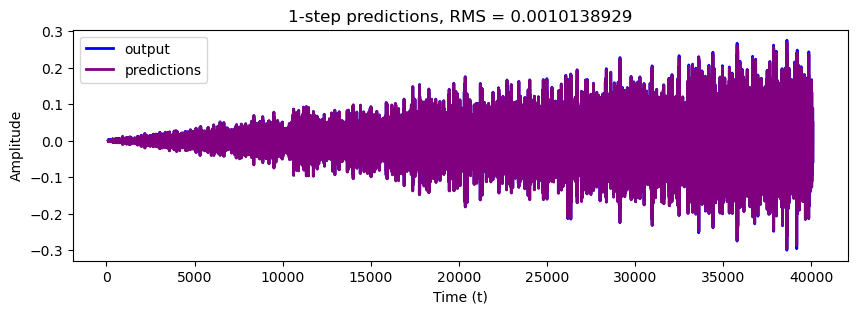

In [34]:
# 1-step ahead predictions
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
# ax.plot(t_val, val_u, c="red", lw=2, label="input")
ax.plot(t_val, val_y, c="blue", lw=2, label="output"); 
ax.plot(t_val, m1_prd_MAP, c="purple", lw=2, label="predictions")
ax.fill_between(t_val, m1_prd_σ05, m1_prd_σ95, color="purple", alpha=0.5)
ax.set_title("1-step predictions, RMS = " + str(RMS_prd_BNN1));
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [35]:
fig.savefig("figures/Silverbox-NARX-BNN1_1prd-predictions.png");

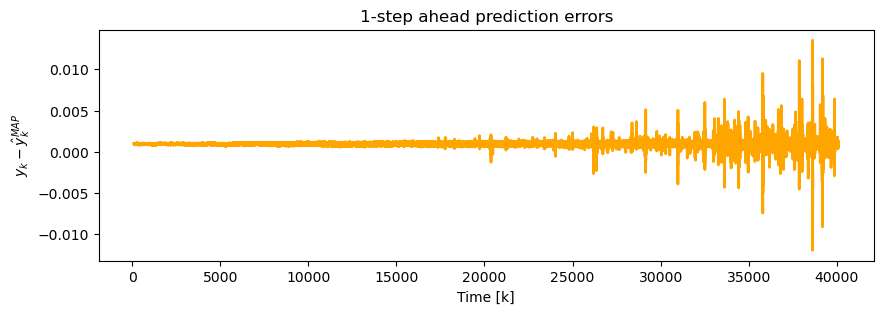

In [36]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.plot(t_val, val_y - m1_prd_MAP, c="orange", lw=2);
ax.set_title("1-step ahead prediction errors");
ax.set_xlabel("Time [k]");
ax.set_ylabel(r"$y_k - \hat{y}_k^{MAP}$");

In [37]:
fig.savefig("figures/Silverbox-NARX-BNN1_1prd-errors.png")

### Model evaluation: simulation errors

In [38]:
# Support structures
S = torch.zeros((order_y,order_y)); S[1:,:-1] = torch.eye(order_y-1)
s = torch.zeros((order_y)); s[0] = 1.0

In [39]:
# Define prediction model
predictor = Predictive(model, guide=guide, num_samples=20, return_sites=("obs", "_RETURN"))

# Initial output predictions
# preds_k = torch.zeros((1,order_y),dtype=torch.float)
preds_k = val_y[:order_y].to(device)

# Preallocate for simulation
m1_sim_MAP = np.zeros((T_val,))
m1_sim_σ05 = np.zeros((T_val,))
m1_sim_σ95 = np.zeros((T_val,))

for k in trange(T_val):
    
    # Simulation 
    sim_x = torch.hstack((val_x[k,:order_u+1], preds_k))
    samples_sim_BNN1 = predictor(sim_x)
    postpred_sim_BNN1 = summary(samples_sim_BNN1)["_RETURN"]
    
    # Keep MAP and interval of posterior predictive
    m1_sim_MAP[k] = postpred_sim_BNN1["mean"].to('cpu')
    m1_sim_σ05[k] = postpred_sim_BNN1["5%"].to('cpu')
    m1_sim_σ95[k] = postpred_sim_BNN1["95%"].to('cpu')
    
    # Update prediction container
    preds_k = S@preds_k + s*postpred_sim_BNN1["mean"]

  0%|          | 0/39999 [00:00<?, ?it/s]

In [40]:
# Compute RMS
RMS_sim_BNN1 = np.array(np.sqrt(torch.mean((val_y - m1_sim_MAP)**2)))    

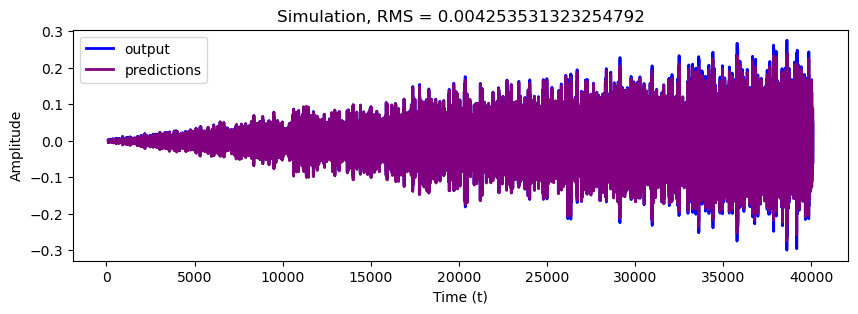

In [41]:
# 1-step ahead predictions
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
# ax.plot(t_val, val_u, c="red", lw=2, label="input")
ax.plot(t_val, val_y, c="blue", lw=2, label="output")
ax.plot(t_val, m1_sim_MAP, c="purple", lw=2, label="predictions")
ax.fill_between(t_val, m1_sim_σ05, m1_sim_σ95, color="purple", alpha=0.5)
ax.set_title("Simulation, RMS = " + str(RMS_sim_BNN1));
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [42]:
fig.savefig("figures/Silverbox-NARX-BNN1_sim-predictions.png");

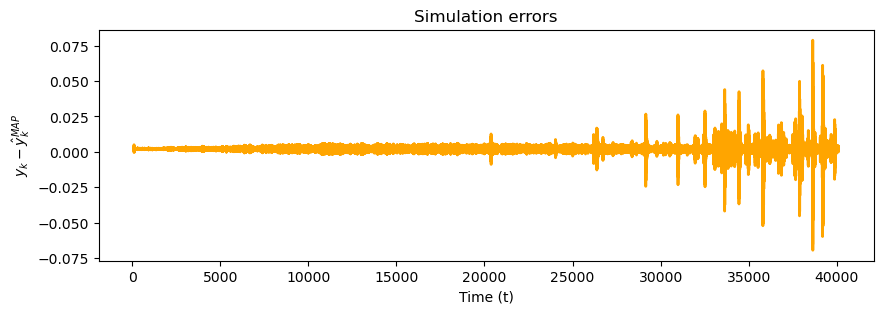

In [43]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.plot(t_val, val_y - m1_sim_MAP, c="orange", lw=2);
ax.set_title("Simulation errors")
ax.set_xlabel("Time (t)");
ax.set_ylabel(r"$y_k - \hat{y}_k^{MAP}$");

In [44]:
fig.savefig("figures/Silverbox-NARX-BNN1_sim-errors.png");

## Model 2: Bayesian neural network (2-layer)

In [45]:
# Define network architecture
neural_network = nn.Sequential(
     nn.Linear(order, 16),
     nn.Tanh(),
     nn.Linear(16, 16),
     nn.Tanh(),
     nn.Linear(16, 1)
 )
 
module.to_pyro_module_(neural_network)
 
for m in neural_network.modules():
    for name, value in list(m.named_parameters(recurse=False)):
        setattr(m, name, module.PyroSample(prior=dist.Normal(0, 1).expand(value.shape).to_event(value.dim())))

In [46]:
class BayesianNeuralNetwork(PyroModule):
    def __init__(self, neural_network):
        super().__init__()
        self.neural_network = neural_network

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0, 1))
        mean = self.neural_network(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [47]:
# Define model and inference procedure
model = BayesianNeuralNetwork(neural_network).to(device)
guide = AutoDiagonalNormal(model)
optimizer = Adam({"lr": 0.01}) 
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [48]:
pyro.clear_param_store()

In [49]:
# Train model
num_iterations = 30000
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(trn_x, trn_y)
    if j % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / T_trn))

[iteration 0001] loss: 1.7643
[iteration 1001] loss: -2.1549
[iteration 2001] loss: -3.3956
[iteration 3001] loss: -3.8880
[iteration 4001] loss: -4.2650
[iteration 5001] loss: -3.6318
[iteration 6001] loss: -4.6003
[iteration 7001] loss: -4.8797
[iteration 8001] loss: -5.1860
[iteration 9001] loss: -5.0905
[iteration 10001] loss: -4.8667
[iteration 11001] loss: -4.8775
[iteration 12001] loss: -4.7927
[iteration 13001] loss: -4.2708
[iteration 14001] loss: -4.7119
[iteration 15001] loss: -5.4597
[iteration 16001] loss: -5.2168
[iteration 17001] loss: -5.5065
[iteration 18001] loss: -5.2060
[iteration 19001] loss: -5.3114
[iteration 20001] loss: -5.4933
[iteration 21001] loss: 0.6781
[iteration 22001] loss: -5.7128
[iteration 23001] loss: -5.6920
[iteration 24001] loss: -2.1393
[iteration 25001] loss: -5.7651
[iteration 26001] loss: -5.5612
[iteration 27001] loss: -5.6567
[iteration 28001] loss: -5.5632
[iteration 29001] loss: -5.7094


### Model evaluation: 1-step ahead prediction error

In [50]:
# Define prediction model
predictor = Predictive(model, guide=guide, num_samples=1000, return_sites=("obs", "_RETURN"))

# 1-step ahead prediction
samples_prd_BNN2 = predictor(val_x)
postpred_prd_BNN2 = summary(samples_prd_BNN2)["_RETURN"]
m2_prd_MAP = postpred_prd_BNN2["mean"].to('cpu')
m2_prd_σ05 = postpred_prd_BNN2["5%"].to('cpu')
m2_prd_σ95 = postpred_prd_BNN2["95%"].to('cpu')

In [51]:
# Compute RMS
RMS_prd_BNN2 = np.array(np.sqrt(torch.mean((val_y - m2_prd_MAP)**2)))

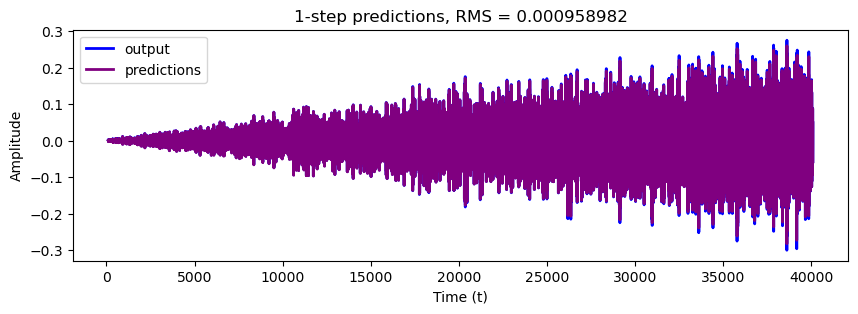

In [52]:
# 1-step ahead predictions
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
# ax.plot(t_val, val_u, c="red", lw=2, label="input")
ax.plot(t_val, val_y, c="blue", lw=2, label="output"); 
ax.plot(t_val, m2_prd_MAP, c="purple", lw=2, label="predictions")
ax.fill_between(t_val, m2_prd_σ05, m2_prd_σ95, color="purple", alpha=0.5)
ax.set_title("1-step predictions, RMS = " + str(RMS_prd_BNN2));
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [53]:
fig.savefig("figures/Silverbox-NARX-BNN2_1prd-predictions.png");

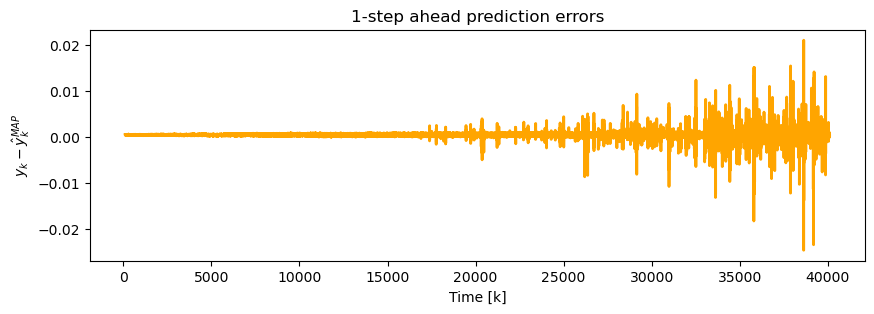

In [54]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.plot(t_val, val_y - m2_prd_MAP, c="orange", lw=2);
ax.set_title("1-step ahead prediction errors");
ax.set_xlabel("Time [k]");
ax.set_ylabel(r"$y_k - \hat{y}_k^{MAP}$");

In [55]:
fig.savefig("figures/Silverbox-NARX-BNN2_1prd-errors.png")

### Model evaluation: simulation errors

In [56]:
# Support structures
S = torch.zeros((order_y,order_y)); S[1:,:-1] = torch.eye(order_y-1)
s = torch.zeros((order_y)); s[0] = 1.0

In [57]:
# Define prediction model
predictor = Predictive(model, guide=guide, num_samples=20, return_sites=("obs", "_RETURN"))

# Initial output predictions
# preds_k = torch.zeros((1,order_y),dtype=torch.float)
preds_k = val_y[:order_y].to(device)

# Preallocate for simulation
m2_sim_MAP = np.zeros((T_val,))
m2_sim_σ05 = np.zeros((T_val,))
m2_sim_σ95 = np.zeros((T_val,))

for k in trange(T_val):
    
    # Simulation 
    sim_x = torch.hstack((val_x[k,:order_u+1], preds_k))
    samples_sim_BNN2 = predictor(sim_x)
    postpred_sim_BNN2 = summary(samples_sim_BNN2)["_RETURN"]
    
    # Keep MAP and interval of posterior predictive
    m2_sim_MAP[k] = postpred_sim_BNN2["mean"].to('cpu')
    m2_sim_σ05[k] = postpred_sim_BNN2["5%"].to('cpu')
    m2_sim_σ95[k] = postpred_sim_BNN2["95%"].to('cpu')
    
    # Update prediction container
    preds_k = S@preds_k + s*postpred_sim_BNN2["mean"]

  0%|          | 0/39999 [00:00<?, ?it/s]

In [58]:
# Compute RMS
RMS_sim_BNN2 = np.array(np.sqrt(torch.mean((val_y - m2_sim_MAP)**2)))    

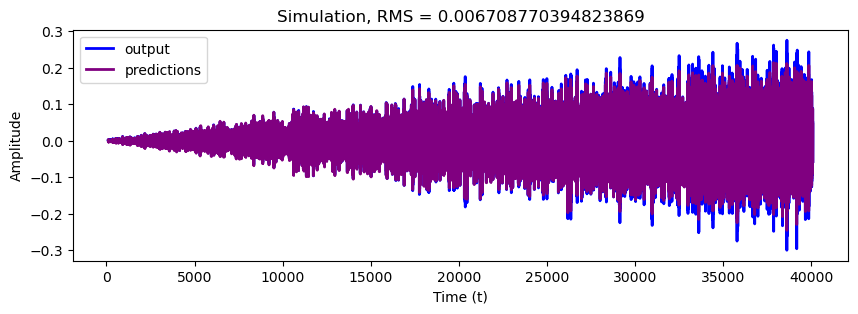

In [59]:
# 1-step ahead predictions
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
# ax.plot(t_val, val_u, c="red", lw=2, label="input")
ax.plot(t_val, val_y, c="blue", lw=2, label="output")
ax.plot(t_val, m2_sim_MAP, c="purple", lw=2, label="predictions")
ax.fill_between(t_val, m2_sim_σ05, m2_sim_σ95, color="purple", alpha=0.5)
ax.set_title("Simulation, RMS = " + str(RMS_sim_BNN2));
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [60]:
fig.savefig("figures/Silverbox-NARX-BNN2_sim-predictions.png");

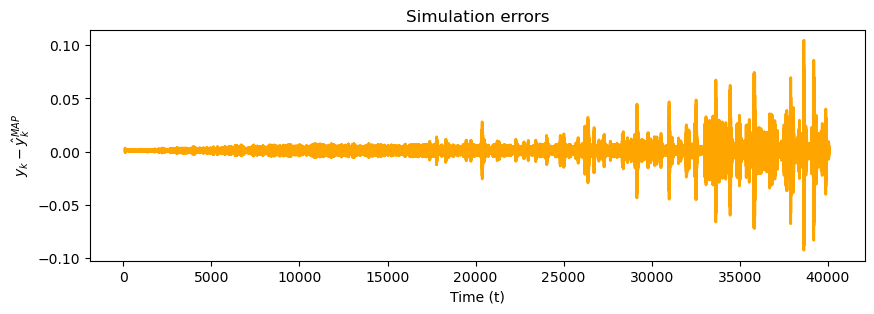

In [61]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.plot(t_val, val_y - m2_sim_MAP, c="orange", lw=2);
ax.set_title("Simulation errors")
ax.set_xlabel("Time (t)");
ax.set_ylabel(r"$y_k - \hat{y}_k^{MAP}$");

In [62]:
fig.savefig("figures/Silverbox-NARX-BNN2_sim-errors.png");

## Model Comparison

In [63]:
# 1-step ahead prediction error
print("RMS 1-step prediction BLR  = " + str(RMS_prd_BLR*1e3) + " mV")
print("RMS 1-step prediction BNN1 = " + str(RMS_prd_BNN1*1e3) + " mV")
print("RMS 1-step prediction BNN2 = " + str(RMS_prd_BNN2*1e3) + " mV")

RMS 1-step prediction BLR  = 1.2072876561433077 mV
RMS 1-step prediction BNN1 = 1.0138929355889559 mV
RMS 1-step prediction BNN2 = 0.9589819819666445 mV


In [65]:
# Simulation error
print("RMS simulation BLR  = " + str(RMS_sim_BLR*1e3) + " mV")
print("RMS simulation BNN1 = " + str(RMS_sim_BNN1*1e3) + " mV")
print("RMS simulation BNN2 = " + str(RMS_sim_BNN2*1e3) + " mV")

RMS simulation BLR  = 13.838349508225395 mV
RMS simulation BNN1 = 4.253531323254792 mV
RMS simulation BNN2 = 6.708770394823869 mV
